
# **Import Libraries**

In [ ]:
from __future__ import print_function

import sklearn
import scipy
import pandas as pd
import numpy as np
import seaborn as sns
import IPython
import matplotlib
import os
import cv2
import csv
import scipy.io

from sklearn.svm import SVC
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import LabelEncoder, StandardScaler, SplineTransformer, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.decomposition import PCA
from sklearn.base import TransformerMixin
from sklearn.compose import TransformedTargetRegressor
from skimage.util import random_noise
from matplotlib import pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


---


## **Load the Dataset & Visualization**

In [3]:
# import the dataset
data = scipy.io.loadmat('/content/drive/MyDrive/Data-hoda-full.mat')

# load the images and labels from dataset
images = data['Data'][:4000]
labels = data['labels'][:4000]

In [4]:
# remove the extra dimension
images = np.squeeze(data['Data'][:4000], axis=1)
labels = np.squeeze(data['labels'][:4000], axis=1)

The size of image 0 is: (27, 20)
The size of image 1 is: (20, 21)
The size of image 2 is: (10, 15)
The size of image 3 is: (36, 17)
The size of image 4 is: (36, 28)


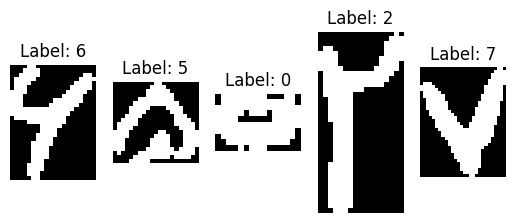

In [5]:
# Show some of the images
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(f"Label: {labels[i]}")
    plt.axis('off')
    size = np.shape(images[i])
    print(f"The size of image {i} is: {(size)}")

plt.show()


## **Image Padding and Resizing**

As the dataset contains images of different sizes, resizing may lead to a loss of information or introduce artifacts; also enlarging smaller images by resizing, could result in the loss of fine details.


- This Function enhances the original image padding process. It determines the maximum height and width among all images in the dataset. However, it goes a step further by symmetrically padding each image. In this process, it calculates the necessary padding for each side (top, bottom, left, and right) to ensure even distribution of the additional height and width (ensuring that the difference in height or width is distributed equally on both sides of the image). By using the np.pad function with these calculated padding values, the function pads each image with zeros in a way that maintains symmetry. This symmetric padding is beneficial for tasks that require balanced adjustments to image dimensions.


The size of image 0 is: (54, 45)
The size of image 1 is: (54, 45)
The size of image 2 is: (54, 45)
The size of image 3 is: (54, 45)
The size of image 4 is: (54, 45)


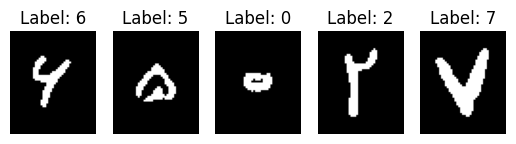

In [6]:
def pad_images(images_dataset):
    max_height = max_width = 0

    # Find maximum dimensions
    for image in images_dataset:
        height, width = image.shape
        max_height = max(max_height, height)
        max_width = max(max_width, width)

    padded_dataset = []

    # Pad images to match maximum dimensions
    for image in images_dataset:
        height, width = image.shape
        pad_height = max_height - height
        pad_width = max_width - width

        # Calculate padding for each side
        top_pad = pad_height // 2
        bottom_pad = pad_height - top_pad
        left_pad = pad_width // 2
        right_pad = pad_width - left_pad

        # Pad image
        padded_image = np.pad(image, ((top_pad, bottom_pad),
                              (left_pad, right_pad)), mode='constant')

        # Add padded image to the dataset
        padded_dataset.append(padded_image)

    return padded_dataset

# use the function to modify the size of images
resized_images = pad_images(images)

# Show some of the images
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(resized_images[i], cmap='gray')
    plt.title(f"Label: {labels[i]}")
    plt.axis('off')
    size = np.shape(resized_images[i])
    print(f"The size of image {i} is: {(size)}")
plt.show()


## **Flatten**

In [7]:
def pad_and_flatten_images(dataset):
    max_height = max_width = 0

    # Find maximum dimensions
    for image in dataset:
        height, width = image.shape
        max_height = max(max_height, height)
        max_width = max(max_width, width)

    padded_and_flattened_dataset = []

    # Pad and flatten images
    for image in dataset:
        height, width = image.shape
        pad_height = max_height - height
        pad_width = max_width - width

        # Pad image
        padded_image = np.pad(image, ((0, pad_height),
                                      (0, pad_width)), mode='constant')

        # Flatten the padded image
        flattened_image = padded_image.flatten()

        # Add flattened image to the dataset
        padded_and_flattened_dataset.append(flattened_image)

    return padded_and_flattened_dataset

# Pad and flatten the images
flattened_images = pad_and_flatten_images(images)


In [8]:
np.shape(flattened_images)

(4000, 2430)

## **Split the Dataset to Train & Test**

In [9]:
# Split the data into Train & Test - 70% Training - 30% Testing
X_train, X_test, y_train, y_test = train_test_split(flattened_images,
                                 labels, test_size=0.3, random_state=42)

In [10]:
print(np.shape(X_train))
print(np.shape(X_test))

(2800, 2430)
(1200, 2430)


## **SVM Classification**


Support Vector Machines (SVMs) can be used for multi class classification by using two methods:

1. **One-vs-One (OvO)**:

  This strategy consists in fitting one classifier per class pair. At prediction time, the class which received the most votes is selected (When making predictions, each classifier gives a vote for one of the two classes in the pair). If there is a tie in votes, It might needs a tie-breaking strategy (e.g., selecting the class with the highest average decision value).
  
  Since it requires to fit n_classes * (n_classes - 1) / 2 classifiers, this method is usually slower than one-vs-the-rest, due to its O(n_classes^2) complexity. However, this method may be advantageous for algorithms such as kernel algorithms which don’t scale well with n_samples. This is because each individual learning problem only involves a small subset of the data whereas, with one-vs-the-rest, the complete dataset is used n_classes times.

  if there is a K classes, For each class i (from 1 to K), create a binary classification problem where the samples of class i are treated as the positive class, and the samples of all other classes are treated as the negative class.


2. **One-vs-All (OvA)** or **One-vs-Rest(OVR)**:

  This strategy consists in fitting one classifier per class. For each classifier, the class is fitted against all the other classes. In addition to its computational efficiency (only n_classes classifiers are needed), one advantage of this approach is its interpretability. Since each class is represented by one and one classifier only, it is possible to gain knowledge about the class by inspecting its corresponding classifier. This is the most commonly used strategy for multiclass classification and is a fair default choice.

  One-Vs-All Classifier can also be used for multilabel classification. To use this feature, provide an indicator matrix for the target y when calling .fit. In other words, the target labels should be formatted as a 2D binary (0/1) matrix, where [i, j] == 1 indicates the presence of label j in sample i. This estimator uses the binary relevance method to perform multilabel classification, which involves training one binary classifier independently for each label.


- analyse the dataset with kernel parameter

### **One-vs-All**:


In [17]:
# define the different kernel types
kernel_types = ['linear', 'rbf', 'poly', 'sigmoid']
i = 0

for kernel in kernel_types:
    # Create an SVM classifier with OvR method
    svm_classifier = OneVsRestClassifier(SVC(kernel=kernel, random_state=42))

    # Train the classifier
    svm_classifier.fit(X_train, y_train)

    # Make predictions
    y_pred = svm_classifier.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # print the results
    if i == 0:
      print("Accuracy in OVR:")

    print(f"in kernel {kernel}: {accuracy}")
    i += 1


Accuracy in OVR:
in kernel linear: 0.7958333333333333
in kernel rbf: 0.9383333333333334
in kernel poly: 0.9341666666666667
in kernel sigmoid: 0.6716666666666666


### **One-vs-One**:


In [13]:
# define the different kernel types
kernel_types = ['linear', 'rbf', 'poly', 'sigmoid']
i = 0

for kernel in kernel_types:
    # Create an SVM classifier with OvO method
    svm_classifier_ovo = OneVsOneClassifier(SVC(kernel=kernel, random_state=42))

    # Train the classifier
    svm_classifier_ovo.fit(X_train, y_train)

    # Make predictions
    y_pred_ovo = svm_classifier_ovo.predict(X_test)

    # Calculate accuracy
    accuracy_ovo = accuracy_score(y_test, y_pred_ovo)

    # print the results
    if i == 0:
      print("Accuracy in OVO:")

    print(f"in kernel {kernel}: {accuracy_ovo}")
    i += 1


Accuracy in OVO:
in kernel linear: 0.8883333333333333
in kernel rbf: 0.9458333333333333
in kernel poly: 0.9208333333333333
in kernel sigmoid: 0.835


- analyse the dataset with kernel & C parameters

In [18]:
# Define the different kernel types
kernel_types = ['linear', 'rbf', 'poly', 'sigmoid']

# Define a range of C values to search over
C_values = [0.01, 0.1, 1.0, 10.0, 100]

# store the best parameters
best_params_per_kernel = {}

for kernel in kernel_types:
    # Create an SVM classifier with OvO method
    svm_classifier_ovo = OneVsOneClassifier(SVC(kernel=kernel, random_state=42))

    # Define the parameter grid for GridSearchCV
    param_grid = {'estimator__C': C_values}

    # Create GridSearchCV object
    grid_search = GridSearchCV(svm_classifier_ovo, param_grid,
                               cv=5, scoring='accuracy')

    # Fit the model to your data
    grid_search.fit(X_train, y_train)

    # Get the best parameters from the grid search
    best_params = grid_search.best_params_

    # Store the best parameters for each kernel type
    best_params_per_kernel[kernel] = best_params

    # Make predictions using the best model
    y_pred_ovo = grid_search.predict(X_test)

    # Calculate accuracy
    accuracy_ovo = accuracy_score(y_test, y_pred_ovo)

    # Print the results
    print(f"Kernel: {kernel}, Best Parameters: {best_params}, Accuracy: {accuracy_ovo}")

# Print the best parameters for each kernel type
print("\nBest Parameters per Kernel:")
for kernel, best_params in best_params_per_kernel.items():
    print(f"Kernel: {kernel}, Best Parameters: {best_params}")


Kernel: linear, Best Parameters: {'estimator__C': 0.01}, Accuracy: 0.8883333333333333
Kernel: rbf, Best Parameters: {'estimator__C': 10.0}, Accuracy: 0.95
Kernel: poly, Best Parameters: {'estimator__C': 10.0}, Accuracy: 0.925
Kernel: sigmoid, Best Parameters: {'estimator__C': 1.0}, Accuracy: 0.835

Best Parameters per Kernel:
Kernel: linear, Best Parameters: {'estimator__C': 0.01}
Kernel: rbf, Best Parameters: {'estimator__C': 10.0}
Kernel: poly, Best Parameters: {'estimator__C': 10.0}
Kernel: sigmoid, Best Parameters: {'estimator__C': 1.0}


## **Model Robustness Analysis in Different Scenarios**

### *Add Salt & Pepper Noise*

In [17]:
# Function to add salt-and-pepper noise to images
def add_noise_Salt_Pepper(images_dataset, amount):
    noisy_dataset = []

    for image in images_dataset:
        # Add pepper and salt noise
        noisy_image = random_noise(image, mode='s&p', amount=amount)

        noisy_image = np.clip(noisy_image, 0, 1)

        noisy_dataset.append(noisy_image)

    return noisy_dataset

# define the different kernel types
kernel_types = ['linear', 'rbf', 'poly', 'sigmoid']

# define the different noise levels
noise_levels = [0.05, 0.1, 0.15, 0.1, 0.2]

for noise_level in noise_levels:
    for kernel in kernel_types:
        # Create an SVM classifier with OvO method
        svm_classifier_ovo = OneVsOneClassifier(SVC(kernel=kernel,
                                                    random_state=42))

        # Train the classifier
        svm_classifier_ovo.fit(X_train, y_train)

        # Add noise to the test set
        noisy_X_test = add_noise_Salt_Pepper(X_test, noise_level)

        # Make predictions on the noisy test set
        y_pred_noisy = svm_classifier_ovo.predict(noisy_X_test)

        # Calculate accuracy on the noisy test set
        accuracy_noisy = accuracy_score(y_test, y_pred_noisy)

        print(f"Accuracy with noise level {noise_level} in kernel {kernel}: {accuracy_noisy}")


Accuracy with noise level 0.05 in kernel linear: 0.09583333333333334
Accuracy with noise level 0.05 in kernel rbf: 0.09
Accuracy with noise level 0.05 in kernel poly: 0.09
Accuracy with noise level 0.05 in kernel sigmoid: 0.10666666666666667
Accuracy with noise level 0.1 in kernel linear: 0.09583333333333334
Accuracy with noise level 0.1 in kernel rbf: 0.09
Accuracy with noise level 0.1 in kernel poly: 0.09
Accuracy with noise level 0.1 in kernel sigmoid: 0.10666666666666667
Accuracy with noise level 0.15 in kernel linear: 0.09583333333333334
Accuracy with noise level 0.15 in kernel rbf: 0.09
Accuracy with noise level 0.15 in kernel poly: 0.09
Accuracy with noise level 0.15 in kernel sigmoid: 0.10666666666666667
Accuracy with noise level 0.1 in kernel linear: 0.09583333333333334
Accuracy with noise level 0.1 in kernel rbf: 0.09
Accuracy with noise level 0.1 in kernel poly: 0.09
Accuracy with noise level 0.1 in kernel sigmoid: 0.10666666666666667
Accuracy with noise level 0.2 in kernel 

As the results show, despite of considering all of the kernels and different range of probabiliries for noise, the accuracies are just about 9% or 10% !

So the dataset is not robust to adding the salt & pepper noise when we use SVM.

### *Add Rotation*

I used 'rbf' kernel here because it was given the best accuracy in previous parts.

- use **cv2.INTER_NEAREST** as a flag

In [30]:
# Function to rotate images
def rotate_images(images, angle):
    rotated_images = []
    for image in images:
        # Reshape the flattened image
        original_shape = size
        reshaped_image = image.reshape(original_shape)

        # Rotate the image by the specified angle
        rotated_image = cv2.warpAffine(reshaped_image,
                                       cv2.getRotationMatrix2D((size[1]/2, size[0]/2), angle, 1.0),
                                       original_shape,
                                       flags=cv2.INTER_NEAREST,
                                       borderMode=cv2.BORDER_CONSTANT,
                                       borderValue=0)
        rotated_images.append(rotated_image.flatten())
    return np.array(rotated_images)

# Rotate the test set by 30 degrees
rotated_X_test = rotate_images(X_test, 30)

# Create an SVM classifier with OvO method
svm_classifier_ovo = OneVsOneClassifier(SVC(kernel='rbf',
                                            random_state=42))

# Train the classifier
svm_classifier_ovo.fit(X_train, y_train)

# Make predictions on the rotated test set
y_pred_rotated = svm_classifier_ovo.predict(rotated_X_test)

# Calculate accuracy on the rotated test set
accuracy_rotated = accuracy_score(y_test, y_pred_rotated)

print(f"Accuracy after rotating test data by 30 degrees: {accuracy_rotated}")


Accuracy after rotating test data by 30 degrees: 0.17583333333333334


- use **cv2.INTER_LINEAR** as a flag

In [33]:
# Function to rotate images
def rotate_images(images, angle):
    rotated_images = []
    for image in images:
        # Reshape the flattened image
        original_shape = size
        reshaped_image = image.reshape(original_shape)

        # Rotate the image by the specified angle
        rotated_image = cv2.warpAffine(reshaped_image,
                                       cv2.getRotationMatrix2D((size[1]/2, size[0]/2), angle, 1.0),
                                       original_shape,
                                       flags=cv2.INTER_LINEAR)
        rotated_images.append(rotated_image.flatten())
    return np.array(rotated_images)

# Rotate the test set by 30 degrees
rotated_X_test = rotate_images(X_test, 30)

# Make predictions on the rotated test set
y_pred_rotated = svm_classifier_ovo.predict(rotated_X_test)

# Calculate accuracy on the rotated test set
accuracy_rotated = accuracy_score(y_test, y_pred_rotated)

print(f"Accuracy after rotating test data by 30 degrees: {accuracy_rotated}")


Accuracy after rotating test data by 30 degrees: 0.18


- use **cv2.INTER_CUBIC** as a flag

In [32]:
# Function to rotate images
def rotate_images(images, angle):
    rotated_images = []
    for image in images:
        # Reshape the flattened image
        original_shape = size
        reshaped_image = image.reshape(original_shape)

        # Rotate the image by the specified angle
        rotated_image = cv2.warpAffine(reshaped_image,
                                       cv2.getRotationMatrix2D((size[1]/2, size[0]/2), angle, 1.0),
                                       original_shape,
                                       flags=cv2.INTER_CUBIC)
        rotated_images.append(rotated_image.flatten())
    return np.array(rotated_images)

# Rotate the test set by 30 degrees
rotated_X_test = rotate_images(X_test, 30)

# Make predictions on the rotated test set
y_pred_rotated = svm_classifier_ovo.predict(rotated_X_test)

# Calculate accuracy on the rotated test set
accuracy_rotated = accuracy_score(y_test, y_pred_rotated)

print(f"Accuracy after rotating test data by 30 degrees: {accuracy_rotated}")


Accuracy after rotating test data by 30 degrees: 0.18166666666666667


In [34]:
# Function to rotate images
def rotate_images(images, angle):
    rotated_images = []
    for image in images:
        # Reshape the flattened image
        original_shape = size
        reshaped_image = image.reshape(original_shape)

        # Rotate the image by the specified angle
        rotated_image = cv2.warpAffine(reshaped_image,
                                       cv2.getRotationMatrix2D((size[1]/2, size[0]/2), angle, 1.0),
                                       original_shape,
                                       flags=cv2.INTER_LANCZOS4)
        rotated_images.append(rotated_image.flatten())
    return np.array(rotated_images)

# Rotate the test set by 30 degrees
rotated_X_test = rotate_images(X_test, 30)

# Make predictions on the rotated test set
y_pred_rotated = svm_classifier_ovo.predict(rotated_X_test)

# Calculate accuracy on the rotated test set
accuracy_rotated = accuracy_score(y_test, y_pred_rotated)

print(f"Accuracy after rotating test data by 30 degrees: {accuracy_rotated}")


Accuracy after rotating test data by 30 degrees: 0.18333333333333332


As the result shows, the accuracy after rotation is low and about 18%. so it means that the dataset is not robust to rotation when we use SVM.